100%|██████████| 572M/572M [00:09<00:00, 65.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1


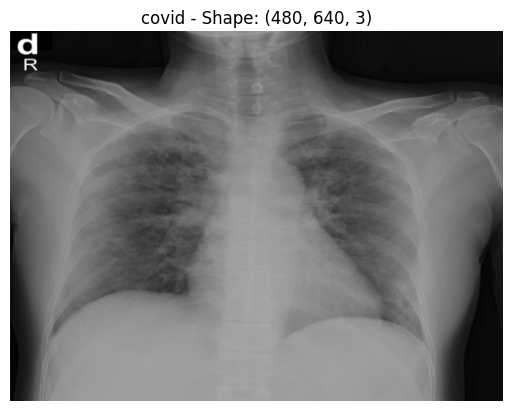

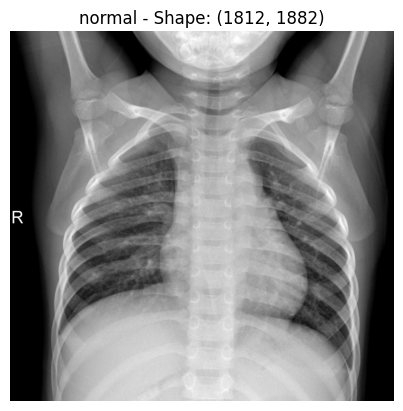

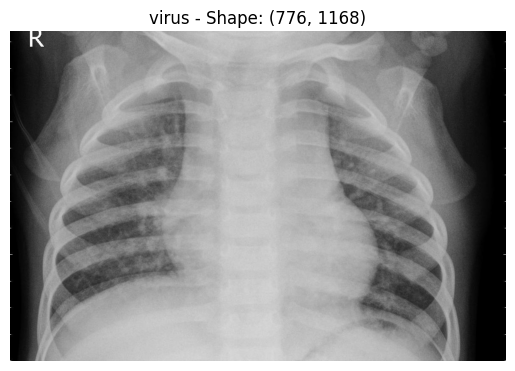

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
37/37 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5550 - loss: 9.9215 - val_accuracy: 0.9041 - val_loss: 0.2956
Epoch 2/3
37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9207 - loss: 0.2454 - val_accuracy: 0.7500 - val_loss: 0.7415
Epoch 3/3
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9563 - loss: 0.1304 - val_accuracy: 0.9384 - val_loss: 0.1582
Test Accuracy: 92.33%


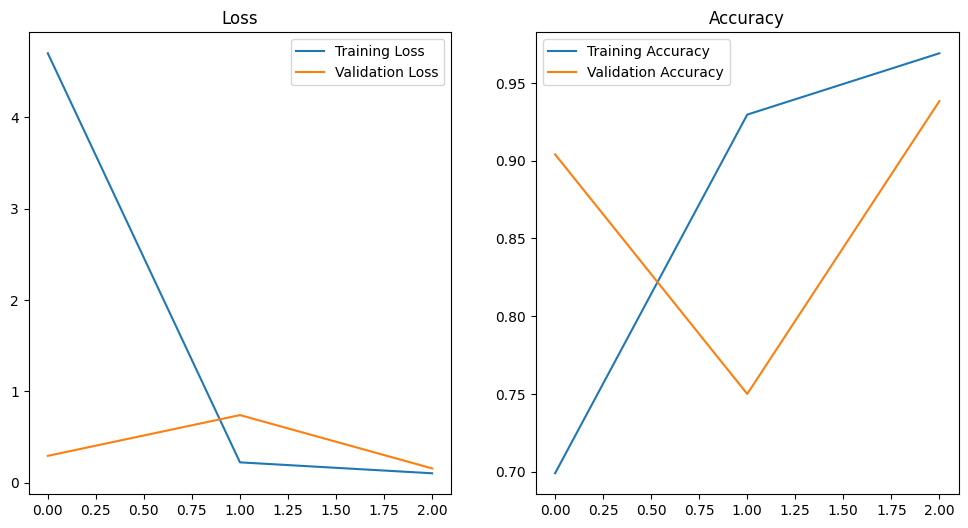

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step
Confusion Matrix:
        covid  normal  virus
covid     107       1      0
normal      3     114     12
virus       2      10    116


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical

# Download dataset using kagglehub
path = kagglehub.dataset_download("sid321axn/covid-cxr-image-dataset-research")
print("Path to dataset files:", path)

# Path setup (update to the downloaded directory)
data_dir = os.path.join(path, "COVID_IEEE")
categories = ["covid", "normal", "virus"]

# Function to display random X-ray image from each class
def view_image(target_class):
    target_folder = os.path.join(data_dir, target_class)
    random_image = random.choice(os.listdir(target_folder))
    img_path = os.path.join(target_folder, random_image)
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap="gray")
    plt.title(f"{target_class} - Shape: {img.shape}")
    plt.axis("off")
    plt.show()

# Display example images
for category in categories:
    view_image(category)

# Preprocess dataset
data, labels = [], []
label_map = {category: i for i, category in enumerate(categories)}

for category in categories:
    folder_path = os.path.join(data_dir, category)
    for file in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, file))
        if img is None:
            continue  # Skip corrupted images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        data.append(img)
        labels.append(label_map[category])

data = np.array(data) / 255.0  # Normalize
labels = to_categorical(labels, num_classes=3)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with minimal epochs
history = model.fit(X_train, y_train, validation_split=0.2, epochs=3, batch_size=32, verbose=1)

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Visualize Training Results
loss_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 6))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(loss_df["loss"], label="Training Loss")
plt.plot(loss_df["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(loss_df["accuracy"], label="Training Accuracy")
plt.plot(loss_df["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

# Predictions and Confusion Matrix
predictions = np.argmax(model.predict(X_test), axis=1)
true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(true_labels, predictions)

# Print Confusion Matrix
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=categories, columns=categories))
